# Calculation of control fields for Lindbladian dynamics using L-BFGS-B algorithm

Christian Arenz (christianarenz.ca@gmail.com), Alexander Pitchford (alex.pitchford@gmail.com)

Example to demonstrate using the control library to determine control pulses using the ctrlpulseoptim.optimize_pulse function. The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which in this case is given by the 'Trace difference' norm.

This in an open quantum system example, with a single qubit subject to an amplitude damping channel. The target evolution is the Hadamard gate. For a $d$ dimensional quantum system in general we represent the Lindbladian
as a $d^2 \times d^2$ dimensional matrix by creating the Liouvillian superoperator. Here done for the Lindbladian that describes the amplitude damping channel. Similarly the control generators acting on the qubit are also converted to superoperators. The initial and target maps also need to be in superoperator form. 

The user can experiment with the strength of the amplitude damping by changing the gamma variable value. If the rate is sufficiently small then the target fidelity can be achieved within the given tolerence. The drift Hamiltonian and control generators can also be swapped and changed to experiment with controllable and uncontrollable setups.

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np

import qutip_qtrl.pulseoptim as cpo
from qutip import (
    gates,
    identity,
    liouvillian,
    sigmam,
    sigmax,
    sigmay,
    sigmaz,
    sprepost,
    about,
)

example_name = "Lindblad"

%matplotlib inline

### Defining the physics

In [2]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)
# Hadamard gate
had_gate = gates.hadamard_transform(1)

# Hamiltonian
Del = 0.1  # Tunnelling term
wq = 1.0  # Energy of the 2-level system.
H0 = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()

# Amplitude damping#
# Damping rate:
gamma = 0.1
L0 = liouvillian(H0, [np.sqrt(gamma) * Sm])

# sigma X control
LC_x = liouvillian(Sx)
# sigma Y control
LC_y = liouvillian(Sy)
# sigma Z control
LC_z = liouvillian(Sz)

# Drift
drift = L0
# Controls - different combinations can be tried
ctrls = [LC_z, LC_x]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(Si, Si)

# target for map evolution
E_targ = sprepost(had_gate, had_gate)

### Defining the time evolution parameters

In [3]:
# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 2

### Set the conditions which will cause the pulse optimisation to terminate

In [4]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 200
# Maximum (elapsed) time allowed in seconds
max_wall_time = 30
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

In [5]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "RND"

### Give an extension for output files

In [6]:
# Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In [7]:
# Note that this call will take the defaults
#    dyn_type='GEN_MAT'
# This means that matrices that describe the dynamics are assumed to be
# general, i.e. the propagator can be calculated using:
# expm(combined_dynamics*dt)
#    prop_type='FRECHET'
# and the propagators and their gradients will be calculated using the
# Frechet method, i.e. an exact gradent
#    fid_type='TRACEDIFF'
# and that the fidelity error, i.e. distance from the target, is give
# by the trace of the difference between the target and evolved operators
result = cpo.optimize_pulse(
    drift,
    ctrls,
    E0,
    E_targ,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    min_grad=min_grad,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    out_file_ext=f_ext,
    init_pulse_type=p_type,
    gen_stats=True,
)

### Report the results

In [8]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print(
    "Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time))
)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:00.909445
Wall time computing Hamiltonians: 0:00:00.016181 (1.78%)
Wall time computing propagators: 0:00:00.798532 (87.80%)
Wall time computing forward propagation: 0:00:00.003219 (0.35%)
Wall time computing onward propagation: 0:00:00.002914 (0.32%)
Wall time computing gradient: 0:00:00.056790 (6.24%)

**** Iterations and function calls ****
Number of iterations: 200
Number of fidelity function calls: 251
Number of times fidelity is computed: 251
Number of gradient function calls: 251
Number of times gradients are computed: 251
Number of times timeslot evolution is recomputed: 251

**** Control amplitudes ****
Number of control amplitude updates: 250
Mean number of updates per iteration: 1.25
Number of timeslot values changed: 2500
Mean number of timeslot changes per update: 10.0
Number of amplitude values changed: 5000
Mean numbe

### Plot the initial and final amplitudes

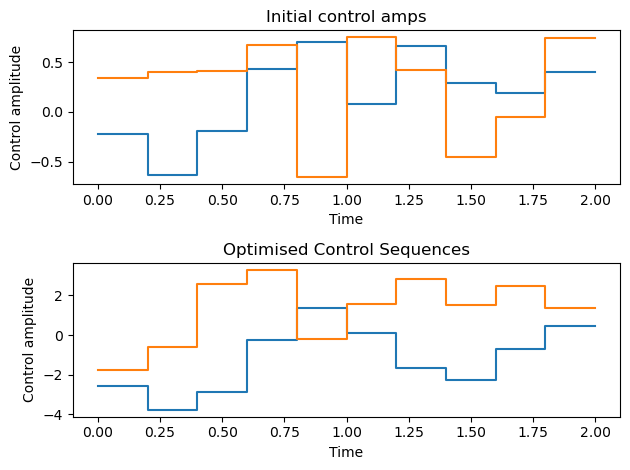

In [9]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(
        result.time,
        np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])),
        where="post",
    )

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(
        result.time,
        np.hstack((result.final_amps[:, j], result.final_amps[-1, j])),
        where="post",
    )
fig1.tight_layout()

### Versions

In [10]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
